In [1]:
# Import packages.
import cvxpy as cp
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
'''
Experiment 1:
in-sample vs out-of-sample
LSMT -> beta vs Transformer -> beta, box, elliposoid -> return
'''

'\nExperiment 1:\nin-sample vs out-of-sample\nLSMT -> beta vs Transformer -> beta, box, elliposoid -> return\n'

In [3]:
import pickle
import os

stocks = pickle.load(open(os.path.dirname(os.path.dirname(os.getcwd()))+'/Prepare_Datasets/indicators.pkl', 'rb'))
samples = list()
for i in stocks:
    samples.append(stocks[i])
samples = np.asarray(samples, dtype=np.float64)
print(samples)

[[-1.03 -0.66 -0.99 ... -0.39 -0.63 -1.03]
 [-0.11 -0.48  0.33 ...  0.23  0.56  0.1 ]
 [-0.51  0.02 -0.56 ... -0.39 -0.05 -0.9 ]
 ...
 [ 0.32  1.33  0.06 ...  0.67  0.33  0.15]
 [ 0.22 -2.24 -0.11 ...  0.17  0.33  0.06]
 [ 0.06 -1.49 -0.38 ... -0.18 -0.39 -0.55]]


In [4]:
sample_size = samples.shape
# stock sample mean
sample_mean = np.mean(samples, axis=0)

# stock sample variance
sample_variance = np.cov(samples, rowvar=False)

print(sample_size)
print(sample_mean)
print(sample_variance)

(2516, 12)
[0.03229332 0.07379173 0.04720588 0.03266296 0.03255167 0.07717806
 0.02060016 0.03517886 0.0540461  0.04485294 0.05078696 0.04417329]
[[0.92167025 1.01341854 0.98275524 0.97815409 0.87386146 0.91080254
  0.78979027 0.83936609 0.80222754 0.74829356 0.99162555 0.90812939]
 [1.01341854 4.36281297 1.81316086 1.68385785 1.22214825 2.03066454
  1.20704484 0.85473578 1.55092577 1.22754378 1.7504963  1.76233526]
 [0.98275524 1.81316086 1.74103891 1.77410601 1.19751592 1.45903271
  1.09818208 0.95176263 1.16854543 1.05092283 1.6247657  1.50373898]
 [0.97815409 1.68385785 1.77410601 3.68994066 1.20409809 1.28433555
  1.15684874 1.09698282 1.02337133 1.00188723 1.82733794 1.54780888]
 [0.87386146 1.22214825 1.19751592 1.20409809 1.13006641 1.10583011
  0.87102352 0.87406813 0.91497476 0.86085501 1.1815605  1.0947301 ]
 [0.91080254 2.03066454 1.45903271 1.28433555 1.10583011 2.00070774
  1.05521207 0.82183478 1.40453214 1.19245847 1.43091367 1.45958777]
 [0.78979027 1.20704484 1.098182

In [5]:
# N assets
N = samples.shape[1]
# S sample
S = samples.shape[0]
# Sigma
Sig = sample_variance
# Sigma^{1/2}
Sig2 = np.linalg.cholesky(Sig)
print(np.allclose(Sig, Sig2 @ Sig2.T)) 
# muhat
mu = sample_mean
#confidence level alpha
alpha = 0.05
# standard norm quantile
z_95 = stats.norm.ppf(1-alpha)
z_975 = stats.norm.ppf(1-alpha/2)
# delta^2 = chi^2 quantile
delta2 = stats.chi2.ppf(1-alpha, df=N)
# lambda0
lambda0 = 0.5

True


In [6]:
# LSTM 
beta0 = 0.33297149767585127
# Transformer
beta1 = 0.33125230431414276

In [7]:
# Box uncertainty set
A = np.hstack((Sig2, np.zeros((N,1))))
e = np.ones(N+1)
e[-1] = 0

In [8]:
# LSTM
c = mu - (1 - 2 * beta0) * (z_975 / np.sqrt(S)) * Sig2 @ np.ones((N))
c = np.append(c, 1)
c = c / ((1 - lambda0) * z_95)
e = np.ones(N + 1)
e[-1] = 0

# Set random seed
np.random.seed(0)
# SOCP
# min  f^T x
# s.t. |||Ax +b|| <=c^T x + d
#      e^T x = 1

# Objective function coefficient
f = np.zeros(N + 1)
f[-1] = 1

# Define variables x = [w, t]^T
x = cp.Variable(N + 1)

# SOC constraints
soc_constraints = [cp.SOC(c.T @ x, A @ x)]

# Define and solve the CVXPY problem
prob = cp.Problem(cp.Minimize(f.T @ x), soc_constraints + [e.T @ x == 1] + [x[:-1] >= 0])
prob.solve() 
w0 = x.value[:-1]
print(w0)
   

[-2.32343714e-09  9.21401245e-10 -8.83521216e-10  2.12061246e-02
  6.39927050e-02  7.77588713e-09  1.73607717e-02  9.03226514e-02
  1.60465157e-01  7.75034381e-02  7.86740659e-02  4.90475081e-01]


In [9]:
# Transformer
c = mu - (1 - 2 * beta1) * (z_975 / np.sqrt(S)) * Sig2 @ np.ones((N))
c = np.append(c, 1)
c = c / ((1 - lambda0) * z_95)
e = np.ones(N + 1)
e[-1] = 0

# Set random seed
np.random.seed(0)
# SOCP
# min  f^T x
# s.t. |||Ax +b|| <=c^T x + d
#      e^T x = 1

# Objective function coefficient
f = np.zeros(N + 1)
f[-1] = 1

# Define variables x = [w, t]^T
x = cp.Variable(N + 1)

# SOC constraints
soc_constraints = [cp.SOC(c.T @ x, A @ x)]

# Define and solve the CVXPY problem
prob = cp.Problem(cp.Minimize(f.T @ x), soc_constraints + [e.T @ x == 1]+ [x[:-1] >= 0])
prob.solve() 
w1 = x.value[:-1]
print(w1)

[-2.35079105e-09  9.31863274e-10 -8.93353515e-10  2.11878913e-02
  6.41036173e-02  7.87906861e-09  1.73928996e-02  9.03402801e-02
  1.60472578e-01  7.74933759e-02  7.86170525e-02  4.90392300e-01]


In [10]:
# Elliptical set
A1 = np.hstack((Sig2, np.zeros((N,1))))
e1 = np.ones(N+1)
e1[-1] = 0

In [11]:
# LSTM
c1 = np.append(mu, 1)
a = (1-lambda0)*z_95 + (1-2*beta0)*np.sqrt(delta2/S)
c1 = c1/a
e = np.ones(N + 1)
e[-1] = 0

# Set random seed
np.random.seed(0)
# SOCP
# min  f^T x
# s.t. |||Ax +b|| <=c^T x + d
#      e^T x = 1

# objective function coeficient
f1 = np.zeros(N + 1)
f1[-1] = 1      

# define variables x=[w,t]^T
x1 = cp.Variable(N+1)
# SOC constraints
soc_constraints1 = [cp.SOC(c1.T @ x1 , A1 @ x1 )]
# Define and solve the CVXPY problem.
prob1 = cp.Problem(cp.Minimize(f1.T@x1),
                soc_constraints1 + [e1.T @ x1 == 1]+ [x1[:-1] >= 0])

prob1.solve()
w10 = x1.value[:-1]
print(w10)


[-1.08908556e-09  4.58140070e-10 -3.98651258e-10  2.30272684e-02
  5.36753727e-02  2.07556391e-09  1.48016430e-02  8.85931092e-02
  1.59213815e-01  7.83554698e-02  8.38514263e-02  4.98481895e-01]


In [12]:
# Transformer
c1 = np.append(mu, 1)
a = (1-lambda0)*z_95 + (1-2*beta1)*np.sqrt(delta2/S)
c1 = c1/a
e = np.ones(N + 1)
e[-1] = 0

# Set random seed
np.random.seed(0)
# SOCP
# min  f^T x
# s.t. |||Ax +b|| <=c^T x + d
#      e^T x = 1

# objective function coeficient
f1 = np.zeros(N + 1)
f1[-1] = 1      

# define variables x=[w,t]^T
x1 = cp.Variable(N+1)
# SOC constraints
soc_constraints1 = [cp.SOC(c1.T @ x1 , A1 @ x1 )]
# Define and solve the CVXPY problem.
prob1 = cp.Problem(cp.Minimize(f1.T@x1),
                soc_constraints1 + [e1.T @ x1 == 1]+ [x1[:-1] >= 0])

prob1.solve()
w11 = x1.value[:-1]
print(w11)


[-1.09005068e-09  4.58770006e-10 -3.98690550e-10  2.30276956e-02
  5.36800201e-02  2.06107036e-09  1.48072760e-02  8.85930157e-02
  1.59208448e-01  7.83542037e-02  8.38478253e-02  4.98481515e-01]


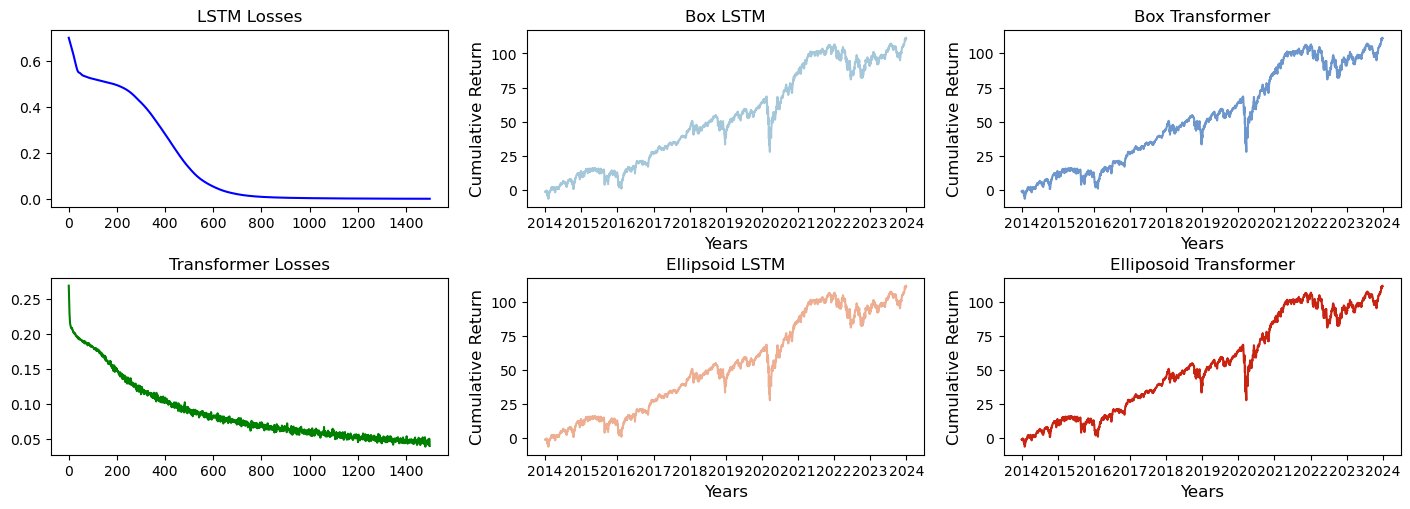

In [18]:
import pickle 

with open("lstm_losses0.pkl", "rb") as f:
    lstm_losses0 = pickle.load(f)
    
with open("transformer_losses0.pkl", "rb") as f:
    transformer_losses0 = pickle.load(f)
    
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

# Add lstm_losses and transformer_losses as the first figure in the first and second rows
axs[0, 0].plot(lstm_losses0, label='LSTM Losses', color='blue')
axs[0, 0].set_title('LSTM Losses')
axs[1, 0].plot(transformer_losses0, label='Transformer Losses', color='green')
axs[1, 0].set_title('Transformer Losses')

axs[0, 1].plot(range(S), result1, label='Box LSTM', color='#a4c8d9')
axs[0, 1].set_title('Box LSTM')
axs[0, 1].set(xlabel='Years', ylabel='Cumulative Return')
axs[0, 1].set_xticks(np.linspace(0, 2516, num=11))
axs[0, 1].set_xticklabels([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])
axs[0, 1].tick_params(axis='both', which='major', labelsize=10)
axs[0, 1].set_xlabel('Years', fontsize=12)
axs[0, 1].set_ylabel('Cumulative Return', fontsize=12)

axs[0, 2].plot(range(S), result2, label='Ellipsoid LSTM', color='#6c96cc')
axs[0, 2].set_title('Box Transformer')
axs[0, 2].set(xlabel='Years', ylabel='Cumulative Return')
axs[0, 2].set_xticks(np.linspace(0, 2516, num=11))
axs[0, 2].set_xticklabels([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])
axs[0, 2].tick_params(axis='both', which='major', labelsize=10)
axs[0, 2].set_xlabel('Years', fontsize=12)
axs[0, 2].set_ylabel('Cumulative Return', fontsize=12)

axs[1, 1].plot(range(S), result3, label='Box Transformer', color='#edae92')
axs[1, 1].set_title('Ellipsoid LSTM')
axs[1, 1].set(xlabel='Years', ylabel='Cumulative Return')
axs[1, 1].set_xticks(np.linspace(0, 2516, num=11))
axs[1, 1].set_xticklabels([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])
axs[1, 1].tick_params(axis='both', which='major', labelsize=10)
axs[1, 1].set_xlabel('Years', fontsize=12)
axs[1, 1].set_ylabel('Cumulative Return', fontsize=12)

axs[1, 2].plot(range(S), result4, label='Elliposoid Transformer', color='#c92312')
axs[1, 2].set_title('Elliposoid Transformer')
axs[1, 2].set(xlabel='Years', ylabel='Cumulative Return')
axs[1, 2].set_xticks(np.linspace(0, 2516, num=11))
axs[1, 2].set_xticklabels([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])
axs[1, 2].tick_params(axis='both', which='major', labelsize=10)
axs[1, 2].set_xlabel('Years', fontsize=12)
axs[1, 2].set_ylabel('Cumulative Return', fontsize=12)

# fig.suptitle('In-sample Experiments', fontsize=1, y=0.99)
# plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(left=0.07, right=0.97, top=0.95, bottom=0.1, hspace=0.4)
# 显示图形
plt.savefig('In-sample.pdf', dpi=800)